In [1]:
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
import importlib
os.chdir(os.getenv('TORCHRBM'))
sys.path.append(os.getcwd() + '/src')
sys.path.append(os.getcwd() + '/data')
sys.path.append(os.getcwd() + '/models')
from scipy.linalg import svd
from h5py import File
import torch
from matplotlib.gridspec import GridSpec
import matplotlib.pyplot as plt
import matplotlib as mpl
from dataset import DatasetRBM
import pandas as pd

In [2]:
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

In [3]:
# use LaTeX fonts in the plots
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'
plt.rcParams.update({'font.size': 15})
plt.rcParams['text.usetex'] = True
plt.rcParams['text.latex.preamble'] = r'\usepackage{bm}'

In [11]:
def get_eigenvalues_hystory(filename):
    f = File(filename, 'r')
    epochs = []
    eigenvalues = []
    for key in f.keys():
        if "epoch" in key:
            weight_matrix = f[key]["weight_matrix"][()]
            weight_matrix = weight_matrix.reshape(-1, weight_matrix.shape[-1])
            eig = svd(weight_matrix, compute_uv=False)
            eigenvalues.append(eig.reshape(*eig.shape, 1))
            epochs.append(int(key.split("_")[1]))
    
    # Sort the results
    sorting = np.argsort(epochs)
    epochs = np.array(epochs)[sorting]
    eigenvalues = np.array(np.hstack(eigenvalues).T)[sorting]
    f.close()
            
    return epochs, eigenvalues

In [12]:
filename = "models/yaakov_short_weighted.h5"
filename_data = "data/yaakov_short.faa"
variable_type = "Potts"

if variable_type == "Potts":
    func = importlib.import_module("torch_utils_categorical")
else:
    func = importlib.import_module("torch_utils_binary")

In [13]:
f = File(filename, "r")
for key in f["hyperparameters"].keys():
    print(key, f["hyperparameters"][key][()])
num_hiddens = f["hyperparameters"]["num_hiddens"][()]

batch_size 1000
epochs 100000
filename b'models/yaakov_short-RBM.h5'
gibbs_steps 10
learning_rate 0.001
num_chains 1000
num_hiddens 500
num_visibles 254
training_mode b'PCD'


In [14]:
f = File(filename, 'r')

pc = torch.tensor(f["parallel_chains"][()], device=device)
epochs = []
for key in f.keys():
    if "epoch" in key:
        ep = int(key.replace("epoch_", ""))
        epochs.append(ep)
        
epochs = np.sort(epochs)
print("epochs:", epochs)
last_ep = f"epoch_{epochs[-1]}"
f.close()

num_data = 5000
dataset = DatasetRBM(path_data=filename_data, compute_weights=True)
data = torch.tensor(dataset.data[:num_data], device=device)
num_visibles = dataset.get_num_visibles()
num_states = dataset.get_num_states()

epochs: [34674 36684 38694 40704 42714 44724 46734 48744 50754 52764 54774 56784
 58794 60804 62814 64824 66834 68844 70854 72864 74874 76884 78894 80904
 82914 84924 86934 88944 90954 92964 94974 96984 98994]
Automatically computing the sequence weights...


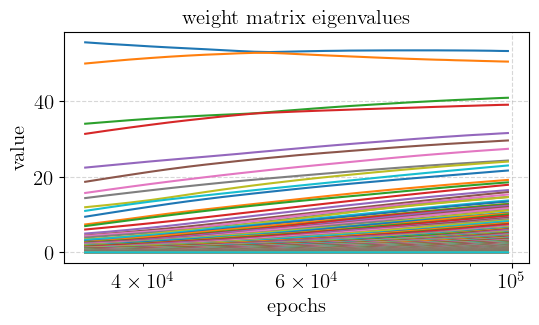

In [15]:
gradient_updates, eigenvalues = get_eigenvalues_hystory(filename)

fig, ax = plt.subplots(dpi=100, nrows=1, ncols=1, figsize=(6, 3))
ax.set_title('weight matrix eigenvalues', size=15)
ax.set_xlabel('epochs')
ax.set_ylabel('value')
ax.set_xscale('log')
#ax.set_yscale('log')
ax.grid(alpha=0.5, ls='dashed')
ax.plot(epochs, eigenvalues);

### Visualize parallel chains against data

In [16]:
if variable_type == 'Potts':
    data_oh = torch.eye(num_states, device=device)[data].float().reshape(-1, num_states * num_visibles)
    cov_data = torch.tensor(dataset.get_covariance_matrix(), device=device).float()
    U_data, S_data, V_dataT = torch.linalg.svd(cov_data)
    data_proj = data_oh @ V_dataT.mT
    pc_oh = torch.eye(num_states, device=device)[pc].float().reshape(-1, num_states * num_visibles)
    pc_proj = pc_oh @ V_dataT.mT
    data_proj = data_proj.cpu().numpy()
    pc_proj = pc_proj.cpu().numpy()
else:
    U_data, S_data, V_dataT = torch.linalg.svd(data - data.mean(0))
    data_proj = data @ V_dataT.mT
    pc_proj = pc @ V_dataT.mT
    data_proj = data_proj.cpu().numpy()
    pc_proj = pc_proj.cpu().numpy()

/tmp/ipykernel_240380/3862491292.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  cov_data = torch.tensor(dataset.get_covariance_matrix(), device=device).float()


In [17]:
def plot_scatter_labels(ax, data_proj, gen_data_proj, proj1, proj2, labels):    
    ax.scatter(data_proj[:, proj1], data_proj[:, proj2], color='black', s=50, label=labels[0], zorder=0, alpha=0.3)
    ax.scatter(gen_data_proj[:, proj1], gen_data_proj[:, proj2], color='red', label=labels[1], s=20, zorder=2, edgecolor='black', marker='o', alpha=1, linewidth=0.4)
    
def plot_hist(ax, data_proj, gen_data_proj, color, proj, labels, orientation='vertical'):    
    ax.hist(data_proj[:, proj], bins=40, color='black', histtype='step', label=labels[0], zorder=0, density=True, orientation=orientation, lw=1)
    ax.hist(gen_data_proj[:, proj], bins=40, color=color, histtype='step', label=labels[1], zorder=1, density=True, orientation=orientation, lw=1.5)
    ax.axis('off')
    
def plot_PCA(data1, data2, labels):
    fig = plt.figure(dpi=100, figsize=(5,5))
    gs = GridSpec(4, 4)

    ax_scatter = fig.add_subplot(gs[1:4, 0:3])
    ax_hist_x = fig.add_subplot(gs[0, 0:3])
    ax_hist_y = fig.add_subplot(gs[1:4, 3])

    plot_scatter_labels(ax_scatter, data1, data2, 0, 1, labels=labels)
    plot_hist(ax_hist_x, data1, data2, 'red', 0, labels=labels)
    plot_hist(ax_hist_y, data1, data2, 'red', 1, orientation='horizontal', labels=labels)

    ax_hist_x.legend(fontsize=12, bbox_to_anchor=(1, 1));
    h, l = ax_scatter.get_legend_handles_labels()

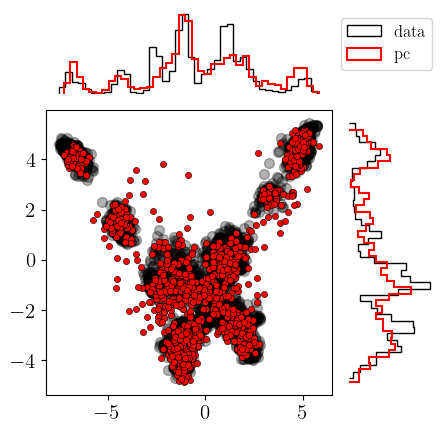

In [18]:
plot_PCA(data_proj, pc_proj, labels=["data", "pc"])

### Generate data

In [19]:
n_gen = 5000
mcmc_steps = 10000
epoch = 98994

epoch = f"epoch_{epoch}"
f = File(filename, 'r')
weight_matrix = torch.tensor(f[epoch]["weight_matrix"][()], device=device)
vbias = torch.tensor(f[epoch]["vbias"][()], device=device)
hbias = torch.tensor(f[epoch]["hbias"][()], device=device)
params = (vbias, hbias, weight_matrix)

if variable_type == "Potts":
    rand_v = torch.randint(0, num_states, size=(n_gen, num_visibles), device=device)
else:
    rand_v = torch.randint(0, 2, size=(n_gen, num_visibles), device=device).float()
rand_h, _ = func.sample_hiddens(rand_v, hbias, weight_matrix)
rand_init = (rand_v, rand_h)
gen, _ = func.sample_state(rand_init, params, mcmc_steps)
if variable_type == 'Potts':
    gen_oh = torch.eye(num_states, device=device)[gen].float().reshape(-1, num_states * num_visibles)
    gen_proj = gen_oh @ V_dataT.mT
else:
    gen_proj = gen @ V_dataT.mT
gen_proj = gen_proj.cpu().numpy()

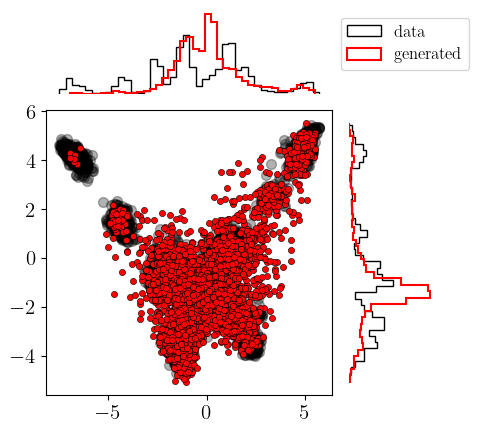

In [20]:
plot_PCA(data_proj, gen_proj, labels=["data", "generated"])